# Triad Covariance

In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import cptools as cp

from ipywidgets import interact

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Load Data
Meta data is printed below cell.

In [2]:
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2.h5"

with h5py.File(path, "r") as f:
    jd = f["JD"][()]
    lst = f["LST"][()]
    frq = f["FRQ"][()]
    eicp_xx = f["eicp med XX 1"][()]
    eicp_yy = f["eicp med YY 1"][()]
    trlist = f["triads"][()]
    flags = f["flags"][()]

# generate frequency array
fmin, fmax, fN = (100, 200, 1024)
df = (fmax - fmin) / fN

# time data
jdmin, jdmax = np.min(jd), np.max(jd)
lstmin, lstmax, lstN = np.min(lst), np.max(lst), len(lst)
dt = (lstmax - lstmin) * 3600 / lstN

Ntrx = eicp_xx.shape[0]
Ntry = eicp_yy.shape[0]
Nlst = eicp_xx.shape[2]

print(f"XX data has shape {eicp_xx.shape}")
print(f"YY data has shape {eicp_yy.shape}")
print(f"JD range {jdmin}-{jdmax}, {len(jd)} nights")
print(r"LST range {:.2f}-{:.2f} h, integration time {:.2f} s".format(lstmin, lstmax, dt))
print(r"frequency range {:.2f}-{:.2f} MHz, channel width {:.4f} MHz".format(min(frq), max(frq), df))

XX data has shape (2, 77, 752, 161)
YY data has shape (2, 84, 752, 161)
JD range 2458033-2458193, 150 nights
LST range 4.00-6.25 h, integration time 10.75 s
frequency range 152.30-167.94 MHz, channel width 0.0977 MHz


## Differences

In [3]:
eicp_xx = (eicp_xx[1] - eicp_xx[0])
eicp_yy = (eicp_yy[1] - eicp_yy[0])

print(f"XX data has shape {eicp_xx.shape}")
print(f"YY data has shape {eicp_yy.shape}")

XX data has shape (77, 752, 161)
YY data has shape (84, 752, 161)


## Plot Noise

In [4]:
def plot_noise(tr, t, noise, ax, pol=""):
    ax.scatter(frq, noise[tr, t].real, color="blue", label="Real")
    ax.scatter(frq, noise[tr, t].imag, color="orange", label="Imaginary")
    ax.hlines(np.sqrt((np.abs(noise[tr, t])**2).mean()), min(frq), max(frq), linestyle="dashed", label="Noise RMS")
    ax.hlines(-np.sqrt((np.abs(noise[tr, t])**2).mean()), min(frq), max(frq), linestyle="dashed")
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Noise (arbirary units)")
    ax.set_title(f"Polarisation {pol}, LST {lst[t].round(2)}, Triad {tr}")
    ax.set_xlim([min(frq), max(frq)])
    ax.set_ylim([-0.5, 0.5])
    return ax

In [5]:
def plot(tr, t):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax = plot_noise(tr, t, eicp_xx, ax, "XX")
    ax.legend(scatterpoints=1)
    
interact(plot, tr=(0, eicp_xx.shape[0]-1), t=(0, eicp_xx.shape[1]-1))

interactive(children=(IntSlider(value=38, description='tr', max=76), IntSlider(value=375, description='t', max…

<function __main__.plot(tr, t)>

In [6]:
def plot(tr, t):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax = plot_noise(tr, t, eicp_xx, ax, "YY")
    ax.legend(scatterpoints=1)
    
interact(plot, tr=(0, eicp_yy.shape[0]-1), t=(0, eicp_yy.shape[1]-1))

interactive(children=(IntSlider(value=41, description='tr', max=83), IntSlider(value=375, description='t', max…

<function __main__.plot(tr, t)>

## Compute Covariance Matrix
The covariance matrix is computed between triads over frequency and for each time integration separately.

In [7]:
cov_xx = np.array([np.cov(eicp_xx[:, i]) for i in range(Nlst)])
cov_yy = np.array([np.cov(eicp_yy[:, i]) for i in range(Nlst)])

print(f"XX covariance has shape {np.shape(cov_xx)}")
print(f"YY covariance has shape {np.shape(cov_yy)}")

XX covariance has shape (752, 77, 77)
YY covariance has shape (752, 84, 84)


## Invert Covariance Matrix

In [8]:
cov_xx_inv = np.array([np.linalg.inv(cov_xx[i]) for i in range(Nlst)])
cov_yy_inv = np.array([np.linalg.inv(cov_yy[i]) for i in range(Nlst)])

## Plot Matrices
Plot the mean absolute value of the covariance matrices.

In [9]:
def plot_cov(cov, ax, pol=""):
    ax.imshow(np.abs(cov).mean(axis=0), vmin=0, vmax=1e-2, interpolation="nearest")
    ax.set_xlabel("Triad Number")
    ax.set_ylabel("Triad Number")
    ax.set_title(f"Covariance Matrix {pol}")
    ax.minorticks_on()
    return ax
    
def plot_cov_inv(cov, ax, pol=""):
    im = ax.imshow(np.abs(cov).mean(axis=0), vmin=0, vmax=1e2, interpolation="nearest")
    ax.set_xlabel("Triad Number")
    ax.set_ylabel("Triad Number")
    ax.set_title(f"Inverse Covariance Matrix {pol}")
    ax.minorticks_on()
    return ax

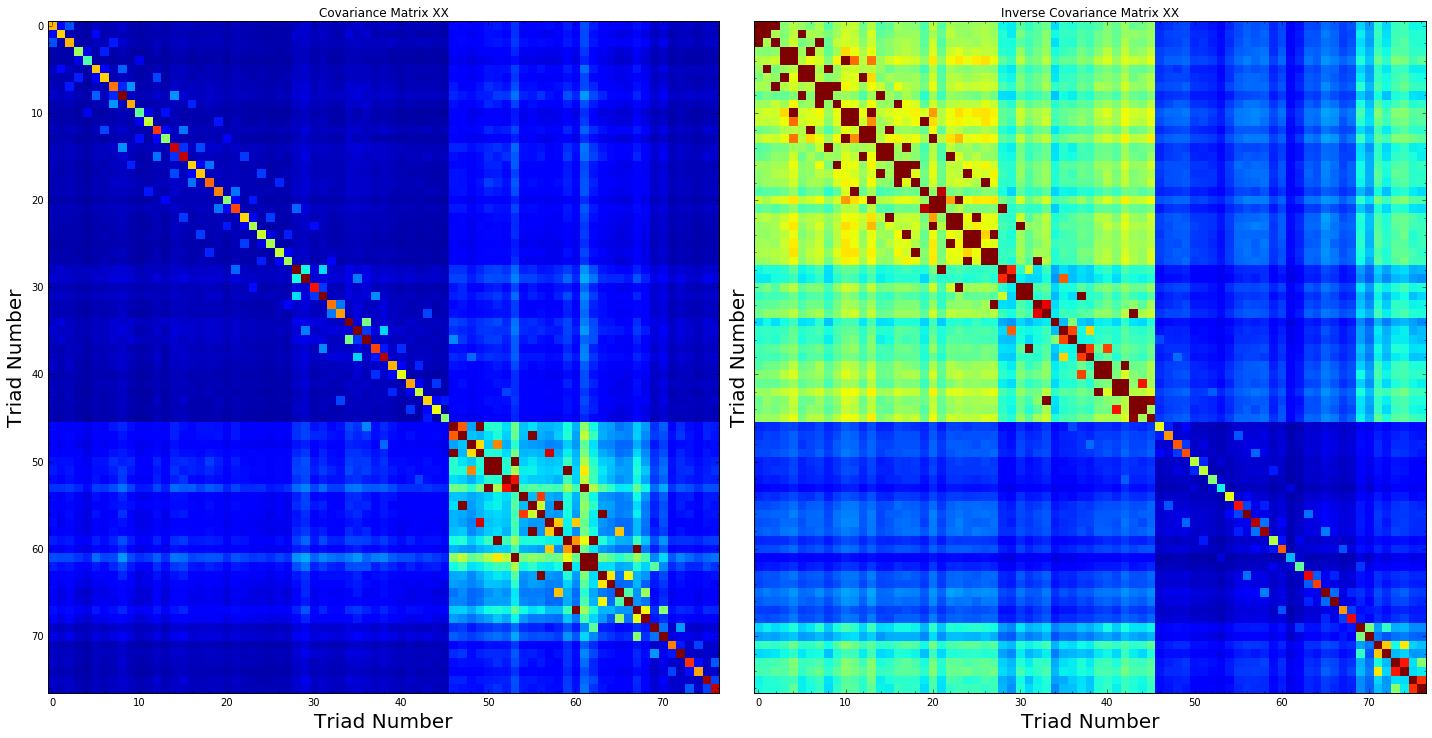

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
ax[0] = plot_cov(cov_xx, ax[0], "XX")
ax[1] = plot_cov_inv(cov_xx_inv, ax[1], "XX")
plt.tight_layout()

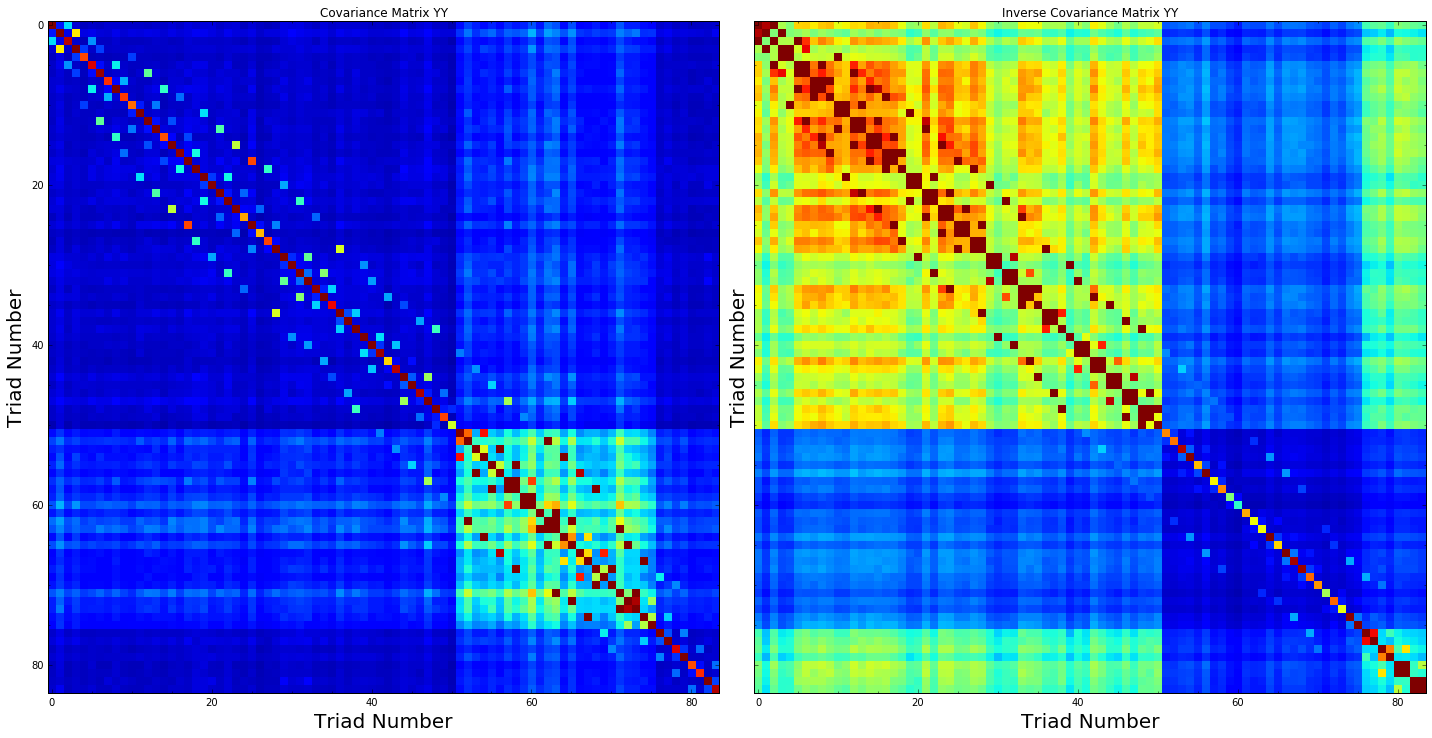

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
ax[0] = plot_cov(cov_yy, ax[0], "YY")
ax[1] = plot_cov_inv(cov_yy_inv, ax[1], "YY")
plt.tight_layout()

## Compute Weights
Weights are computed vor each time integration separately.

In [12]:
# inverse covariance weights
w_cov_xx = np.sum(cov_xx_inv, axis=1)
w_cov_yy = np.sum(cov_yy_inv, axis=1)

# inverse variance weights
w_var_xx = [1 / np.diag(cov_xx[i]) for i in range(Nlst)]
w_var_yy = [1 / np.diag(cov_yy[i]) for i in range(Nlst)]

# Normalise
w_cov_xx = np.moveaxis(w_cov_xx, 0, 1) / np.sum(w_cov_xx, axis=1)
w_cov_yy = np.moveaxis(w_cov_yy, 0, 1) / np.sum(w_cov_yy, axis=1)
w_var_xx = np.moveaxis(w_var_xx, 0, 1) / np.sum(w_var_xx, axis=1)
w_var_yy = np.moveaxis(w_var_yy, 0, 1) / np.sum(w_var_yy, axis=1)

print(f"XX weights have shape {w_cov_xx.shape}")
print(f"YY weights have shape {w_cov_yy.shape}")

XX weights have shape (77, 752)
YY weights have shape (84, 752)


## Plot Weights
Plot the mean weights per triad.

In [13]:
def plot_weights(w_cov, w_var, ax, pol="", **kwargs):
    step = np.arange(1, w_cov.shape[0]+1)
    ax.bar(step-0.2, w_cov.mean(axis=1), 0.4, linewidth=0, label="Covariance Weights", color="blue", **kwargs)
    ax.bar(step+0.2, w_var.mean(axis=1), 0.4, linewidth=0, label="Variance Weights", color="orange", **kwargs)
    ax.set_xlim([min(step)-1, max(step)+1])
    ax.set_xlabel("Triad Number")
    ax.set_ylabel("Weight")
    ax.set_title(f"Mean Triad Weights {pol}")
    return ax

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


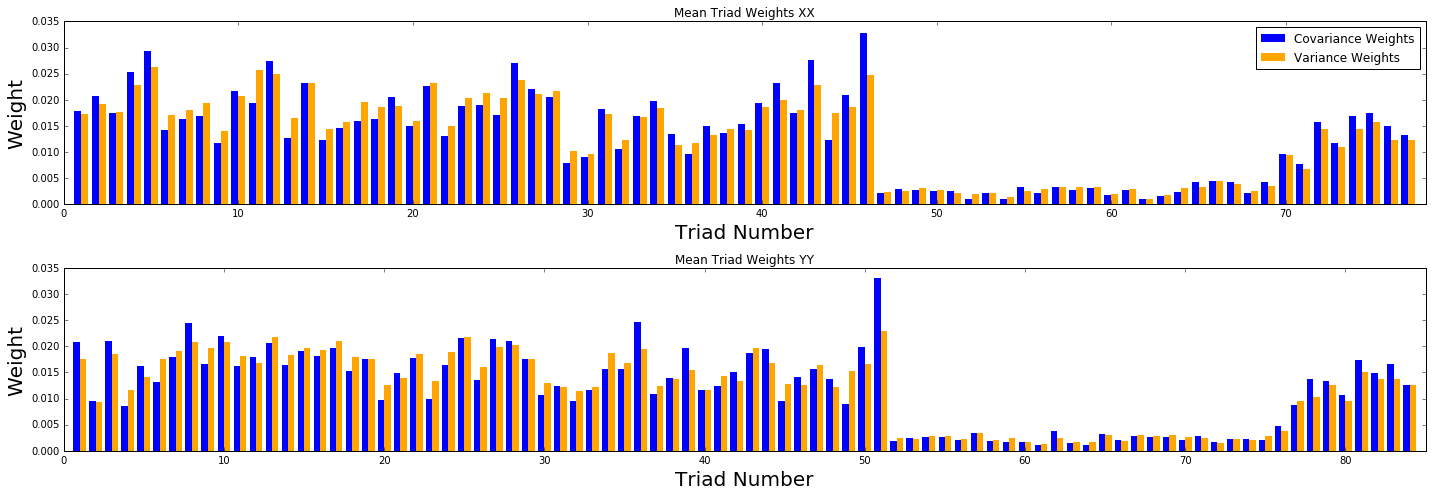

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
ax[0] = plot_weights(w_cov_xx, w_var_xx, ax[0], "XX")
ax[1] = plot_weights(w_cov_yy, w_var_yy, ax[1], "YY")
ax[0].legend()
plt.tight_layout()

## Compute Noise Levels
This is done for four different averaging methods:
(I) No weighting, 
(II) Variance weighting, 
(III) Covariance Weighting, 
(IV) Geometric median averaging

In [15]:
import imp; imp.reload(cp)

# noise averages XX
noise_xx_1 = np.mean(eicp_xx, axis=0)
noise_xx_2 = (w_var_xx * np.moveaxis(eicp_xx, -1, 0)).sum(axis=1)
noise_xx_3 = (w_cov_xx * np.moveaxis(eicp_xx, -1, 0)).sum(axis=1)
noise_xx_4 = cp.geomed(eicp_xx, axis=0)
noise_xx_5 = [cp.geomed(eicp_xx[:, i], w_var_xx[:, i], axis=0) for i in range(Nlst)]

# noise averages YY
noise_yy_1 = np.mean(eicp_yy, axis=0)
noise_yy_2 = (w_var_yy * np.moveaxis(eicp_yy, -1, 0)).sum(axis=1)
noise_yy_3 = (w_cov_yy * np.moveaxis(eicp_yy, -1, 0)).sum(axis=1)
noise_yy_4 = cp.geomed(eicp_yy, axis=0)
noise_yy_5 = [cp.geomed(eicp_yy[:, i], w_var_yy[:, i], axis=0) for i in range(Nlst)]

print(f"XX noise has shape {noise_xx_1.shape}")
print(f"YY noise has shape {noise_yy_1.shape}")

XX noise has shape (752, 161)
YY noise has shape (752, 161)


In [16]:
# noise variances XX
sig_xx_1 = np.sqrt(np.mean(np.abs(noise_xx_1)**2, axis=-1))
sig_xx_2 = np.sqrt(np.mean(np.abs(noise_xx_2)**2, axis=0))
sig_xx_3 = np.sqrt(np.mean(np.abs(noise_xx_3)**2, axis=0))
sig_xx_4 = np.sqrt(np.mean(np.abs(noise_xx_4)**2, axis=-1))
sig_xx_5 = np.sqrt(np.mean(np.abs(noise_xx_5)**2, axis=-1))

# noise variances YY
sig_yy_1 = np.sqrt(np.mean(np.abs(noise_yy_1)**2, axis=-1))
sig_yy_2 = np.sqrt(np.mean(np.abs(noise_yy_2)**2, axis=0))
sig_yy_3 = np.sqrt(np.mean(np.abs(noise_yy_3)**2, axis=0))
sig_yy_4 = np.sqrt(np.mean(np.abs(noise_yy_4)**2, axis=-1))
sig_yy_5 = np.sqrt(np.mean(np.abs(noise_yy_5)**2, axis=-1))

## Plots Noise Levels
Plot noise levels as a function of time.

In [17]:
def plot_sig(sig, ax, pol="", **kwargs):
    ax.plot(lst, sig, linewidth=0.8, **kwargs)
    ax.set_xlim([min(lst), max(lst)])
    ax.set_xlabel("LST (h)")
    ax.set_ylabel("Noise Level (arbitrary units)")
    ax.set_title(f"Noise Levels after Averaging, {pol}")
    return ax

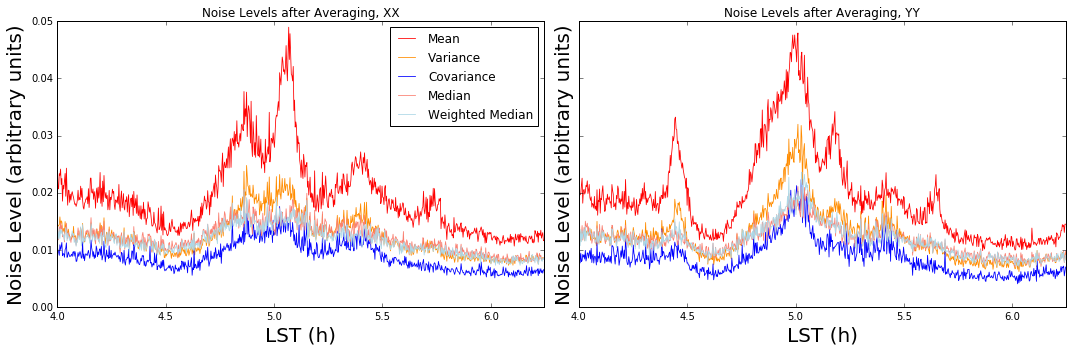

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0] = plot_sig(sig_xx_1, ax[0], pol="XX", color="red", label="Mean")
ax[0] = plot_sig(sig_xx_2, ax[0], pol="XX", color="darkorange", label="Variance")
ax[0] = plot_sig(sig_xx_3, ax[0], pol="XX", color="blue", label="Covariance")
ax[0] = plot_sig(sig_xx_4, ax[0], pol="XX", color="salmon", label="Median")
ax[0] = plot_sig(sig_xx_5, ax[0], pol="XX", color="lightblue", label="Weighted Median")
ax[1] = plot_sig(sig_yy_1, ax[1], pol="YY", color="red", label="Mean")
ax[1] = plot_sig(sig_yy_2, ax[1], pol="YY", color="darkorange",label="Variance")
ax[1] = plot_sig(sig_yy_3, ax[1], pol="YY", color="blue", label="Covariance")
ax[1] = plot_sig(sig_yy_4, ax[1], pol="YY", color="salmon", label="Median")
ax[1] = plot_sig(sig_yy_5, ax[1], pol="YY", color="lightblue", label="Weighted Median")
ax[0].legend()
plt.tight_layout()

In [19]:
print("Relative improvements in sensitivity XX:")
print(f"Variance: {np.mean(sig_xx_1 / sig_xx_2)}")
print(f"Covariance: {np.mean(sig_xx_1 / sig_xx_3)}")
print(f"Median: {np.mean(sig_xx_1 / sig_xx_4)}")
print(f"Weighted Median: {np.mean(sig_xx_1 / sig_xx_5)}")

print("\nRelative improvements in sensitivity YY:")
print(f"Variance: {np.mean(sig_yy_1 / sig_yy_2)}")
print(f"Covariance: {np.mean(sig_yy_1 / sig_yy_3)}")
print(f"Median: {np.mean(sig_yy_1 / sig_yy_4)}")
print(f"Weighted Median: {np.mean(sig_yy_1 / sig_yy_5)}")

Relative improvements in sensitivity XX:
Variance: 1.5596005270412288
Covariance: 2.1731096167253305
Median: 1.5788615942001343
Weighted Median: 1.6537449359893799

Relative improvements in sensitivity YY:
Variance: 1.5346804214525502
Covariance: 2.2369872934805484
Median: 1.6181522607803345
Weighted Median: 1.623610496520996
